##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Transfer learning and fine-tuning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.preprocessing.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

    8192/68606236 [..............................] - ETA: 1s

 4202496/68606236 [>.............................] - ETA: 1s

12787712/68606236 [====>.........................] - ETA: 0s

16785408/68606236 [======>.......................] - ETA: 0s

28000256/68606236 [===========>..................] - ETA: 0s

33562624/68606236 [=============>................] - ETA: 0s

45957120/68606236 [===================>..........] - ETA: 0s

58728448/68606236 [========================>.....] - ETA: 0s

68608000/68606236 [==============================] - 1s 0us/step


Found 2000 files belonging to 2 classes.


In [5]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

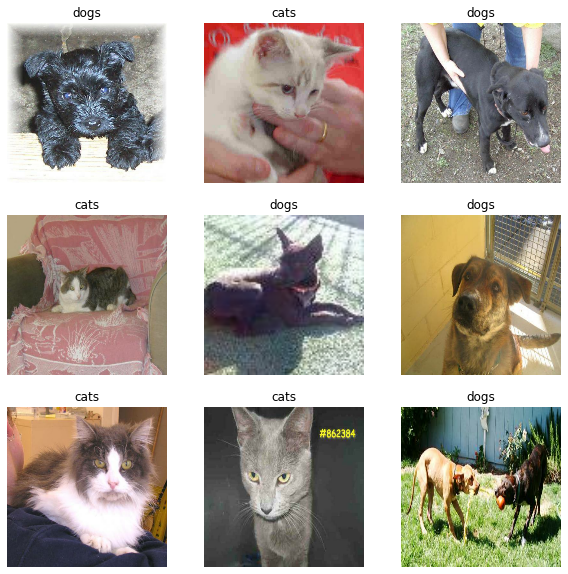

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using ```tf.data.experimental.cardinality```, then move 20% of them to a test set.

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `model.fit`. They are inactive when the model is used in inference mode in `model.evaulate` or `model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

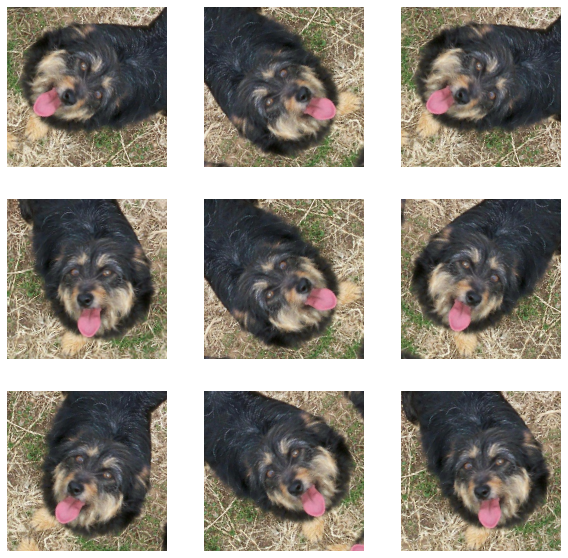

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1,1]`, but at this point, the pixel values in your images are in `[0-255]`. To rescale them, use the preprocessing method included with the model.

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0,255]` to `[-1, 1]` using a [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) layer.

In [13]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1,1]` or `[0,1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [14]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

   8192/9406464 [..............................] - ETA: 0s

5513216/9406464 [================>.............] - ETA: 0s

9412608/9406464 [==============================] - 0s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [16]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [17]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [19]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [20]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [23]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [24]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

 1/26 [>.............................] - ETA: 34s - loss: 0.8797 - accuracy: 0.4688

 5/26 [====>.........................] - ETA: 0s - loss: 0.8767 - accuracy: 0.4437 

 9/26 [=========>....................] - ETA: 0s - loss: 0.8485 - accuracy: 0.4618

13/26 [==============>...............] - ETA: 0s - loss: 0.8706 - accuracy: 0.4351

17/26 [==================>...........] - ETA: 0s - loss: 0.8640 - accuracy: 0.4283

22/26 [========================>.....] - ETA: 0s - loss: 0.8762 - accuracy: 0.4148

26/26 [==============================] - ETA: 0s - loss: 0.8761 - accuracy: 0.4245

26/26 [==============================] - 2s 17ms/step - loss: 0.8761 - accuracy: 0.4245


In [25]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.88
initial accuracy: 0.42


In [26]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


 1/63 [..............................] - ETA: 2:25 - loss: 1.0532 - accuracy: 0.4062

 5/63 [=>............................] - ETA: 0s - loss: 0.9366 - accuracy: 0.4375  

 9/63 [===>..........................] - ETA: 0s - loss: 0.9148 - accuracy: 0.4514

13/63 [=====>........................] - ETA: 0s - loss: 0.9258 - accuracy: 0.4303

17/63 [=======>......................] - ETA: 0s - loss: 0.9223 - accuracy: 0.4357

21/63 [=========>....................] - ETA: 0s - loss: 0.9266 - accuracy: 0.4286

25/63 [==========>...................] - ETA: 0s - loss: 0.9072 - accuracy: 0.4338

29/63 [============>.................] - ETA: 0s - loss: 0.8950 - accuracy: 0.4429

33/63 [==============>...............] - ETA: 0s - loss: 0.8818 - accuracy: 0.4536

37/63 [================>.............] - ETA: 0s - loss: 0.8693 - accuracy: 0.4637

41/63 [==================>...........] - ETA: 0s - loss: 0.8517 - accuracy: 0.4688

45/63 [====================>.........] - ETA: 0s - loss: 0.8452 - accuracy: 0.4743

49/63 [======================>.......] - ETA: 0s - loss: 0.8341 - accuracy: 0.4783

53/63 [========================>.....] - ETA: 0s - loss: 0.8272 - accuracy: 0.4858

57/63 [==========================>...] - ETA: 0s - loss: 0.8132 - accuracy: 0.4978

61/63 [============================>.] - ETA: 0s - loss: 0.8052 - accuracy: 0.5051

63/63 [==============================] - ETA: 0s - loss: 0.8011 - accuracy: 0.5085

63/63 [==============================] - 4s 23ms/step - loss: 0.8011 - accuracy: 0.5085 - val_loss: 0.6102 - val_accuracy: 0.6646


Epoch 2/10
 1/63 [..............................] - ETA: 5s - loss: 0.6841 - accuracy: 0.6875

 5/63 [=>............................] - ETA: 0s - loss: 0.6757 - accuracy: 0.6313

 9/63 [===>..........................] - ETA: 0s - loss: 0.6470 - accuracy: 0.6250

13/63 [=====>........................] - ETA: 0s - loss: 0.6781 - accuracy: 0.6130

17/63 [=======>......................] - ETA: 0s - loss: 0.6745 - accuracy: 0.6048

21/63 [=========>....................] - ETA: 0s - loss: 0.6768 - accuracy: 0.6131

25/63 [==========>...................] - ETA: 0s - loss: 0.6566 - accuracy: 0.6237

29/63 [============>.................] - ETA: 0s - loss: 0.6449 - accuracy: 0.6315

33/63 [==============>...............] - ETA: 0s - loss: 0.6423 - accuracy: 0.6316

37/63 [================>.............] - ETA: 0s - loss: 0.6462 - accuracy: 0.6309

41/63 [==================>...........] - ETA: 0s - loss: 0.6352 - accuracy: 0.6372

45/63 [====================>.........] - ETA: 0s - loss: 0.6265 - accuracy: 0.6451

49/63 [======================>.......] - ETA: 0s - loss: 0.6207 - accuracy: 0.6480

53/63 [========================>.....] - ETA: 0s - loss: 0.6162 - accuracy: 0.6492

57/63 [==========================>...] - ETA: 0s - loss: 0.6083 - accuracy: 0.6546

61/63 [============================>.] - ETA: 0s - loss: 0.5995 - accuracy: 0.6634

63/63 [==============================] - 1s 21ms/step - loss: 0.5971 - accuracy: 0.6650 - val_loss: 0.4344 - val_accuracy: 0.7921


Epoch 3/10
 1/63 [..............................] - ETA: 5s - loss: 0.5055 - accuracy: 0.7188

 5/63 [=>............................] - ETA: 0s - loss: 0.4994 - accuracy: 0.7188

 9/63 [===>..........................] - ETA: 0s - loss: 0.5216 - accuracy: 0.7083

13/63 [=====>........................] - ETA: 0s - loss: 0.5121 - accuracy: 0.7212

17/63 [=======>......................] - ETA: 0s - loss: 0.5182 - accuracy: 0.7132

21/63 [=========>....................] - ETA: 0s - loss: 0.5160 - accuracy: 0.7158

25/63 [==========>...................] - ETA: 0s - loss: 0.4993 - accuracy: 0.7262

29/63 [============>.................] - ETA: 0s - loss: 0.5004 - accuracy: 0.7188

33/63 [==============>...............] - ETA: 0s - loss: 0.4914 - accuracy: 0.7254

37/63 [================>.............] - ETA: 0s - loss: 0.4891 - accuracy: 0.7280

41/63 [==================>...........] - ETA: 0s - loss: 0.4913 - accuracy: 0.7233

45/63 [====================>.........] - ETA: 0s - loss: 0.4828 - accuracy: 0.7347

49/63 [======================>.......] - ETA: 0s - loss: 0.4791 - accuracy: 0.7404

53/63 [========================>.....] - ETA: 0s - loss: 0.4729 - accuracy: 0.7476

57/63 [==========================>...] - ETA: 0s - loss: 0.4711 - accuracy: 0.7511

61/63 [============================>.] - ETA: 0s - loss: 0.4665 - accuracy: 0.7582

63/63 [==============================] - 1s 21ms/step - loss: 0.4634 - accuracy: 0.7600 - val_loss: 0.3227 - val_accuracy: 0.8725


Epoch 4/10
 1/63 [..............................] - ETA: 5s - loss: 0.4223 - accuracy: 0.8125

 5/63 [=>............................] - ETA: 0s - loss: 0.4103 - accuracy: 0.7563

 9/63 [===>..........................] - ETA: 0s - loss: 0.4158 - accuracy: 0.7778

13/63 [=====>........................] - ETA: 0s - loss: 0.4199 - accuracy: 0.7812

17/63 [=======>......................] - ETA: 0s - loss: 0.4199 - accuracy: 0.7794

21/63 [=========>....................] - ETA: 0s - loss: 0.4168 - accuracy: 0.7798

25/63 [==========>...................] - ETA: 0s - loss: 0.4103 - accuracy: 0.7900

29/63 [============>.................] - ETA: 0s - loss: 0.4132 - accuracy: 0.7899

33/63 [==============>...............] - ETA: 0s - loss: 0.4123 - accuracy: 0.7917

37/63 [================>.............] - ETA: 0s - loss: 0.4095 - accuracy: 0.7948

41/63 [==================>...........] - ETA: 0s - loss: 0.4082 - accuracy: 0.7927

45/63 [====================>.........] - ETA: 0s - loss: 0.4052 - accuracy: 0.7972

49/63 [======================>.......] - ETA: 0s - loss: 0.3996 - accuracy: 0.8004

53/63 [========================>.....] - ETA: 0s - loss: 0.3966 - accuracy: 0.8042

57/63 [==========================>...] - ETA: 0s - loss: 0.3912 - accuracy: 0.8092

61/63 [============================>.] - ETA: 0s - loss: 0.3894 - accuracy: 0.8120

63/63 [==============================] - 1s 21ms/step - loss: 0.3881 - accuracy: 0.8135 - val_loss: 0.2745 - val_accuracy: 0.8800


Epoch 5/10
 1/63 [..............................] - ETA: 4s - loss: 0.3456 - accuracy: 0.8438

 5/63 [=>............................] - ETA: 0s - loss: 0.3595 - accuracy: 0.8062

 9/63 [===>..........................] - ETA: 0s - loss: 0.3715 - accuracy: 0.7882

13/63 [=====>........................] - ETA: 0s - loss: 0.3540 - accuracy: 0.8029

17/63 [=======>......................] - ETA: 0s - loss: 0.3694 - accuracy: 0.8162

21/63 [=========>....................] - ETA: 0s - loss: 0.3548 - accuracy: 0.8244

25/63 [==========>...................] - ETA: 0s - loss: 0.3584 - accuracy: 0.8225

29/63 [============>.................] - ETA: 0s - loss: 0.3590 - accuracy: 0.8254

33/63 [==============>...............] - ETA: 0s - loss: 0.3522 - accuracy: 0.8324

37/63 [================>.............] - ETA: 0s - loss: 0.3485 - accuracy: 0.8370

41/63 [==================>...........] - ETA: 0s - loss: 0.3501 - accuracy: 0.8331

45/63 [====================>.........] - ETA: 0s - loss: 0.3474 - accuracy: 0.8354

49/63 [======================>.......] - ETA: 0s - loss: 0.3448 - accuracy: 0.8393

53/63 [========================>.....] - ETA: 0s - loss: 0.3446 - accuracy: 0.8390

57/63 [==========================>...] - ETA: 0s - loss: 0.3434 - accuracy: 0.8383

61/63 [============================>.] - ETA: 0s - loss: 0.3416 - accuracy: 0.8422

63/63 [==============================] - 1s 21ms/step - loss: 0.3407 - accuracy: 0.8420 - val_loss: 0.2215 - val_accuracy: 0.9208


Epoch 6/10
 1/63 [..............................] - ETA: 5s - loss: 0.3311 - accuracy: 0.8125

 5/63 [=>............................] - ETA: 0s - loss: 0.3500 - accuracy: 0.8188

 9/63 [===>..........................] - ETA: 0s - loss: 0.3358 - accuracy: 0.8229

13/63 [=====>........................] - ETA: 0s - loss: 0.3245 - accuracy: 0.8317

17/63 [=======>......................] - ETA: 0s - loss: 0.3263 - accuracy: 0.8235

21/63 [=========>....................] - ETA: 0s - loss: 0.3182 - accuracy: 0.8363

25/63 [==========>...................] - ETA: 0s - loss: 0.3081 - accuracy: 0.8475

29/63 [============>.................] - ETA: 0s - loss: 0.3074 - accuracy: 0.8459

33/63 [==============>...............] - ETA: 0s - loss: 0.3095 - accuracy: 0.8485

37/63 [================>.............] - ETA: 0s - loss: 0.3111 - accuracy: 0.8488

41/63 [==================>...........] - ETA: 0s - loss: 0.3097 - accuracy: 0.8483

45/63 [====================>.........] - ETA: 0s - loss: 0.3079 - accuracy: 0.8507

49/63 [======================>.......] - ETA: 0s - loss: 0.3086 - accuracy: 0.8508

53/63 [========================>.....] - ETA: 0s - loss: 0.3066 - accuracy: 0.8526

57/63 [==========================>...] - ETA: 0s - loss: 0.3042 - accuracy: 0.8536

61/63 [============================>.] - ETA: 0s - loss: 0.3071 - accuracy: 0.8519

63/63 [==============================] - 1s 21ms/step - loss: 0.3061 - accuracy: 0.8535 - val_loss: 0.1885 - val_accuracy: 0.9332


Epoch 7/10
 1/63 [..............................] - ETA: 5s - loss: 0.3963 - accuracy: 0.6875

 5/63 [=>............................] - ETA: 0s - loss: 0.2748 - accuracy: 0.8687

 9/63 [===>..........................] - ETA: 0s - loss: 0.2953 - accuracy: 0.8576

13/63 [=====>........................] - ETA: 0s - loss: 0.2968 - accuracy: 0.8582

17/63 [=======>......................] - ETA: 0s - loss: 0.2869 - accuracy: 0.8676

21/63 [=========>....................] - ETA: 0s - loss: 0.2787 - accuracy: 0.8735

25/63 [==========>...................] - ETA: 0s - loss: 0.2739 - accuracy: 0.8775

29/63 [============>.................] - ETA: 0s - loss: 0.2790 - accuracy: 0.8739

33/63 [==============>...............] - ETA: 0s - loss: 0.2793 - accuracy: 0.8693

37/63 [================>.............] - ETA: 0s - loss: 0.2773 - accuracy: 0.8733

41/63 [==================>...........] - ETA: 0s - loss: 0.2814 - accuracy: 0.8697

45/63 [====================>.........] - ETA: 0s - loss: 0.2805 - accuracy: 0.8694

49/63 [======================>.......] - ETA: 0s - loss: 0.2795 - accuracy: 0.8705

53/63 [========================>.....] - ETA: 0s - loss: 0.2775 - accuracy: 0.8726

57/63 [==========================>...] - ETA: 0s - loss: 0.2796 - accuracy: 0.8723

61/63 [============================>.] - ETA: 0s - loss: 0.2787 - accuracy: 0.8750

63/63 [==============================] - 1s 21ms/step - loss: 0.2763 - accuracy: 0.8760 - val_loss: 0.1680 - val_accuracy: 0.9468


Epoch 8/10
 1/63 [..............................] - ETA: 5s - loss: 0.2781 - accuracy: 0.8750

 5/63 [=>............................] - ETA: 0s - loss: 0.2803 - accuracy: 0.8875

 9/63 [===>..........................] - ETA: 0s - loss: 0.2668 - accuracy: 0.8681

13/63 [=====>........................] - ETA: 0s - loss: 0.2648 - accuracy: 0.8678

17/63 [=======>......................] - ETA: 0s - loss: 0.2610 - accuracy: 0.8695

21/63 [=========>....................] - ETA: 0s - loss: 0.2681 - accuracy: 0.8601

25/63 [==========>...................] - ETA: 0s - loss: 0.2642 - accuracy: 0.8700

29/63 [============>.................] - ETA: 0s - loss: 0.2674 - accuracy: 0.8685

33/63 [==============>...............] - ETA: 0s - loss: 0.2696 - accuracy: 0.8703

37/63 [================>.............] - ETA: 0s - loss: 0.2629 - accuracy: 0.8758

41/63 [==================>...........] - ETA: 0s - loss: 0.2606 - accuracy: 0.8788

45/63 [====================>.........] - ETA: 0s - loss: 0.2632 - accuracy: 0.8799

49/63 [======================>.......] - ETA: 0s - loss: 0.2648 - accuracy: 0.8782

53/63 [========================>.....] - ETA: 0s - loss: 0.2621 - accuracy: 0.8815

57/63 [==========================>...] - ETA: 0s - loss: 0.2580 - accuracy: 0.8838

61/63 [============================>.] - ETA: 0s - loss: 0.2612 - accuracy: 0.8796

63/63 [==============================] - 1s 21ms/step - loss: 0.2614 - accuracy: 0.8800 - val_loss: 0.1570 - val_accuracy: 0.9431


Epoch 9/10
 1/63 [..............................] - ETA: 5s - loss: 0.2669 - accuracy: 0.9062

 5/63 [=>............................] - ETA: 0s - loss: 0.2429 - accuracy: 0.9000

 9/63 [===>..........................] - ETA: 0s - loss: 0.2316 - accuracy: 0.9062

13/63 [=====>........................] - ETA: 0s - loss: 0.2373 - accuracy: 0.9111

17/63 [=======>......................] - ETA: 0s - loss: 0.2560 - accuracy: 0.8952

21/63 [=========>....................] - ETA: 0s - loss: 0.2575 - accuracy: 0.8914

25/63 [==========>...................] - ETA: 0s - loss: 0.2570 - accuracy: 0.8925

29/63 [============>.................] - ETA: 0s - loss: 0.2550 - accuracy: 0.8912

33/63 [==============>...............] - ETA: 0s - loss: 0.2538 - accuracy: 0.8892

37/63 [================>.............] - ETA: 0s - loss: 0.2535 - accuracy: 0.8910

41/63 [==================>...........] - ETA: 0s - loss: 0.2484 - accuracy: 0.8933

45/63 [====================>.........] - ETA: 0s - loss: 0.2466 - accuracy: 0.8944

49/63 [======================>.......] - ETA: 0s - loss: 0.2494 - accuracy: 0.8929

53/63 [========================>.....] - ETA: 0s - loss: 0.2509 - accuracy: 0.8909

57/63 [==========================>...] - ETA: 0s - loss: 0.2475 - accuracy: 0.8942

61/63 [============================>.] - ETA: 0s - loss: 0.2464 - accuracy: 0.8955

63/63 [==============================] - 1s 21ms/step - loss: 0.2445 - accuracy: 0.8960 - val_loss: 0.1388 - val_accuracy: 0.9505


Epoch 10/10
 1/63 [..............................] - ETA: 5s - loss: 0.2629 - accuracy: 0.9062

 5/63 [=>............................] - ETA: 0s - loss: 0.2094 - accuracy: 0.9250

 9/63 [===>..........................] - ETA: 0s - loss: 0.2002 - accuracy: 0.9236

13/63 [=====>........................] - ETA: 0s - loss: 0.2087 - accuracy: 0.9231

17/63 [=======>......................] - ETA: 0s - loss: 0.2128 - accuracy: 0.9173

21/63 [=========>....................] - ETA: 0s - loss: 0.2161 - accuracy: 0.9196

25/63 [==========>...................] - ETA: 0s - loss: 0.2171 - accuracy: 0.9137

29/63 [============>.................] - ETA: 0s - loss: 0.2184 - accuracy: 0.9116

33/63 [==============>...............] - ETA: 0s - loss: 0.2250 - accuracy: 0.9062

37/63 [================>.............] - ETA: 0s - loss: 0.2244 - accuracy: 0.9054

41/63 [==================>...........] - ETA: 0s - loss: 0.2223 - accuracy: 0.9093

45/63 [====================>.........] - ETA: 0s - loss: 0.2259 - accuracy: 0.9056

49/63 [======================>.......] - ETA: 0s - loss: 0.2249 - accuracy: 0.9056

53/63 [========================>.....] - ETA: 0s - loss: 0.2249 - accuracy: 0.9068

57/63 [==========================>...] - ETA: 0s - loss: 0.2227 - accuracy: 0.9062

61/63 [============================>.] - ETA: 0s - loss: 0.2221 - accuracy: 0.9068

63/63 [==============================] - 1s 21ms/step - loss: 0.2221 - accuracy: 0.9075 - val_loss: 0.1301 - val_accuracy: 0.9641


### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

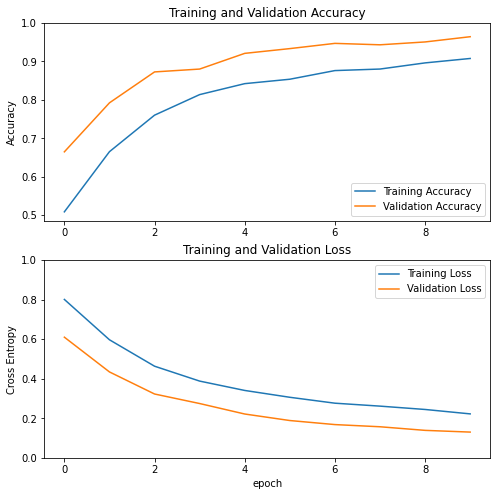

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [28]:
base_model.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [32]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [33]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


 1/63 [..............................] - ETA: 4:12 - loss: 0.1661 - accuracy: 0.9688

 4/63 [>.............................] - ETA: 1s - loss: 0.1778 - accuracy: 0.9375  

 7/63 [==>...........................] - ETA: 1s - loss: 0.1686 - accuracy: 0.9420

10/63 [===>..........................] - ETA: 1s - loss: 0.1620 - accuracy: 0.9375

13/63 [=====>........................] - ETA: 1s - loss: 0.1516 - accuracy: 0.9447

16/63 [======>.......................] - ETA: 1s - loss: 0.1619 - accuracy: 0.9395

19/63 [========>.....................] - ETA: 0s - loss: 0.1556 - accuracy: 0.9424

22/63 [=========>....................] - ETA: 0s - loss: 0.1503 - accuracy: 0.9446

25/63 [==========>...................] - ETA: 0s - loss: 0.1491 - accuracy: 0.9425

28/63 [============>.................] - ETA: 0s - loss: 0.1502 - accuracy: 0.9408

31/63 [=============>................] - ETA: 0s - loss: 0.1519 - accuracy: 0.9415

34/63 [===============>..............] - ETA: 0s - loss: 0.1507 - accuracy: 0.9430

37/63 [================>.............] - ETA: 0s - loss: 0.1518 - accuracy: 0.9409

40/63 [==================>...........] - ETA: 0s - loss: 0.1490 - accuracy: 0.9422

43/63 [===================>..........] - ETA: 0s - loss: 0.1507 - accuracy: 0.9419

46/63 [====================>.........] - ETA: 0s - loss: 0.1482 - accuracy: 0.9416

49/63 [======================>.......] - ETA: 0s - loss: 0.1475 - accuracy: 0.9420

52/63 [=======================>......] - ETA: 0s - loss: 0.1432 - accuracy: 0.9435

55/63 [=========================>....] - ETA: 0s - loss: 0.1420 - accuracy: 0.9432

58/63 [==========================>...] - ETA: 0s - loss: 0.1448 - accuracy: 0.9418

61/63 [============================>.] - ETA: 0s - loss: 0.1453 - accuracy: 0.9416

63/63 [==============================] - ETA: 0s - loss: 0.1445 - accuracy: 0.9425

63/63 [==============================] - 7s 41ms/step - loss: 0.1445 - accuracy: 0.9425 - val_loss: 0.0730 - val_accuracy: 0.9703


Epoch 11/20
 1/63 [..............................] - ETA: 5s - loss: 0.1992 - accuracy: 0.9375

 4/63 [>.............................] - ETA: 1s - loss: 0.1100 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 1s - loss: 0.1231 - accuracy: 0.9643

10/63 [===>..........................] - ETA: 1s - loss: 0.0989 - accuracy: 0.9750

13/63 [=====>........................] - ETA: 1s - loss: 0.0971 - accuracy: 0.9663

16/63 [======>.......................] - ETA: 1s - loss: 0.0923 - accuracy: 0.9688

19/63 [========>.....................] - ETA: 0s - loss: 0.1111 - accuracy: 0.9589

22/63 [=========>....................] - ETA: 0s - loss: 0.1172 - accuracy: 0.9560

25/63 [==========>...................] - ETA: 0s - loss: 0.1178 - accuracy: 0.9563

28/63 [============>.................] - ETA: 0s - loss: 0.1145 - accuracy: 0.9576

31/63 [=============>................] - ETA: 0s - loss: 0.1142 - accuracy: 0.9567

34/63 [===============>..............] - ETA: 0s - loss: 0.1124 - accuracy: 0.9568

37/63 [================>.............] - ETA: 0s - loss: 0.1103 - accuracy: 0.9578

40/63 [==================>...........] - ETA: 0s - loss: 0.1194 - accuracy: 0.9539

43/63 [===================>..........] - ETA: 0s - loss: 0.1180 - accuracy: 0.9549

46/63 [====================>.........] - ETA: 0s - loss: 0.1207 - accuracy: 0.9511

49/63 [======================>.......] - ETA: 0s - loss: 0.1217 - accuracy: 0.9477

52/63 [=======================>......] - ETA: 0s - loss: 0.1276 - accuracy: 0.9441

55/63 [=========================>....] - ETA: 0s - loss: 0.1271 - accuracy: 0.9443

58/63 [==========================>...] - ETA: 0s - loss: 0.1257 - accuracy: 0.9445

61/63 [============================>.] - ETA: 0s - loss: 0.1271 - accuracy: 0.9452

63/63 [==============================] - 2s 28ms/step - loss: 0.1270 - accuracy: 0.9450 - val_loss: 0.0473 - val_accuracy: 0.9790


Epoch 12/20
 1/63 [..............................] - ETA: 5s - loss: 0.2033 - accuracy: 0.8750

 4/63 [>.............................] - ETA: 1s - loss: 0.1438 - accuracy: 0.9219

 7/63 [==>...........................] - ETA: 1s - loss: 0.1533 - accuracy: 0.9330

10/63 [===>..........................] - ETA: 1s - loss: 0.1356 - accuracy: 0.9438

13/63 [=====>........................] - ETA: 1s - loss: 0.1194 - accuracy: 0.9543

16/63 [======>.......................] - ETA: 1s - loss: 0.1073 - accuracy: 0.9570

19/63 [========>.....................] - ETA: 0s - loss: 0.1106 - accuracy: 0.9556

22/63 [=========>....................] - ETA: 0s - loss: 0.1146 - accuracy: 0.9531

25/63 [==========>...................] - ETA: 0s - loss: 0.1164 - accuracy: 0.9513

28/63 [============>.................] - ETA: 0s - loss: 0.1167 - accuracy: 0.9509

31/63 [=============>................] - ETA: 0s - loss: 0.1139 - accuracy: 0.9536

34/63 [===============>..............] - ETA: 0s - loss: 0.1126 - accuracy: 0.9540

37/63 [================>.............] - ETA: 0s - loss: 0.1119 - accuracy: 0.9535

40/63 [==================>...........] - ETA: 0s - loss: 0.1130 - accuracy: 0.9531

43/63 [===================>..........] - ETA: 0s - loss: 0.1189 - accuracy: 0.9506

46/63 [====================>.........] - ETA: 0s - loss: 0.1176 - accuracy: 0.9504

49/63 [======================>.......] - ETA: 0s - loss: 0.1161 - accuracy: 0.9503

52/63 [=======================>......] - ETA: 0s - loss: 0.1108 - accuracy: 0.9531

55/63 [=========================>....] - ETA: 0s - loss: 0.1127 - accuracy: 0.9523

58/63 [==========================>...] - ETA: 0s - loss: 0.1120 - accuracy: 0.9531

61/63 [============================>.] - ETA: 0s - loss: 0.1108 - accuracy: 0.9539

63/63 [==============================] - 2s 29ms/step - loss: 0.1100 - accuracy: 0.9540 - val_loss: 0.0620 - val_accuracy: 0.9703


Epoch 13/20
 1/63 [..............................] - ETA: 5s - loss: 0.0335 - accuracy: 0.9688

 4/63 [>.............................] - ETA: 1s - loss: 0.1158 - accuracy: 0.9531

 7/63 [==>...........................] - ETA: 1s - loss: 0.1300 - accuracy: 0.9375

 9/63 [===>..........................] - ETA: 1s - loss: 0.1098 - accuracy: 0.9479

12/63 [====>.........................] - ETA: 1s - loss: 0.1057 - accuracy: 0.9505

15/63 [======>.......................] - ETA: 1s - loss: 0.0996 - accuracy: 0.9521

18/63 [=======>......................] - ETA: 1s - loss: 0.0974 - accuracy: 0.9531

21/63 [=========>....................] - ETA: 0s - loss: 0.0963 - accuracy: 0.9539

24/63 [==========>...................] - ETA: 0s - loss: 0.0892 - accuracy: 0.9596

27/63 [===========>..................] - ETA: 0s - loss: 0.0888 - accuracy: 0.9595

30/63 [=============>................] - ETA: 0s - loss: 0.0857 - accuracy: 0.9615

33/63 [==============>...............] - ETA: 0s - loss: 0.0874 - accuracy: 0.9602

36/63 [================>.............] - ETA: 0s - loss: 0.0858 - accuracy: 0.9618

39/63 [=================>............] - ETA: 0s - loss: 0.0864 - accuracy: 0.9615

42/63 [===================>..........] - ETA: 0s - loss: 0.0850 - accuracy: 0.9628

45/63 [====================>.........] - ETA: 0s - loss: 0.0848 - accuracy: 0.9632

48/63 [=====================>........] - ETA: 0s - loss: 0.0893 - accuracy: 0.9622

51/63 [=======================>......] - ETA: 0s - loss: 0.0919 - accuracy: 0.9596

54/63 [========================>.....] - ETA: 0s - loss: 0.0911 - accuracy: 0.9606

57/63 [==========================>...] - ETA: 0s - loss: 0.0983 - accuracy: 0.9578

60/63 [===========================>..] - ETA: 0s - loss: 0.0976 - accuracy: 0.9578

63/63 [==============================] - ETA: 0s - loss: 0.0996 - accuracy: 0.9570

63/63 [==============================] - 2s 30ms/step - loss: 0.0996 - accuracy: 0.9570 - val_loss: 0.0418 - val_accuracy: 0.9839


Epoch 14/20
 1/63 [..............................] - ETA: 5s - loss: 0.1140 - accuracy: 0.9688

 4/63 [>.............................] - ETA: 1s - loss: 0.0752 - accuracy: 0.9766

 7/63 [==>...........................] - ETA: 1s - loss: 0.0609 - accuracy: 0.9866

10/63 [===>..........................] - ETA: 1s - loss: 0.0824 - accuracy: 0.9781

13/63 [=====>........................] - ETA: 1s - loss: 0.0721 - accuracy: 0.9784

16/63 [======>.......................] - ETA: 1s - loss: 0.0794 - accuracy: 0.9746

19/63 [========>.....................] - ETA: 1s - loss: 0.0796 - accuracy: 0.9720

22/63 [=========>....................] - ETA: 0s - loss: 0.0794 - accuracy: 0.9702

25/63 [==========>...................] - ETA: 0s - loss: 0.0840 - accuracy: 0.9700

28/63 [============>.................] - ETA: 0s - loss: 0.0897 - accuracy: 0.9699

31/63 [=============>................] - ETA: 0s - loss: 0.0858 - accuracy: 0.9698

34/63 [===============>..............] - ETA: 0s - loss: 0.0889 - accuracy: 0.9697

37/63 [================>.............] - ETA: 0s - loss: 0.0899 - accuracy: 0.9679

40/63 [==================>...........] - ETA: 0s - loss: 0.0878 - accuracy: 0.9680

43/63 [===================>..........] - ETA: 0s - loss: 0.0863 - accuracy: 0.9680

46/63 [====================>.........] - ETA: 0s - loss: 0.0873 - accuracy: 0.9667

49/63 [======================>.......] - ETA: 0s - loss: 0.0869 - accuracy: 0.9668

52/63 [=======================>......] - ETA: 0s - loss: 0.0890 - accuracy: 0.9657

55/63 [=========================>....] - ETA: 0s - loss: 0.0887 - accuracy: 0.9659

58/63 [==========================>...] - ETA: 0s - loss: 0.0889 - accuracy: 0.9639

61/63 [============================>.] - ETA: 0s - loss: 0.0870 - accuracy: 0.9652

63/63 [==============================] - 2s 29ms/step - loss: 0.0859 - accuracy: 0.9650 - val_loss: 0.0331 - val_accuracy: 0.9839


Epoch 15/20
 1/63 [..............................] - ETA: 5s - loss: 0.0253 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 1s - loss: 0.0276 - accuracy: 0.9922

 7/63 [==>...........................] - ETA: 1s - loss: 0.0493 - accuracy: 0.9777

10/63 [===>..........................] - ETA: 1s - loss: 0.0495 - accuracy: 0.9812

13/63 [=====>........................] - ETA: 1s - loss: 0.0522 - accuracy: 0.9808

16/63 [======>.......................] - ETA: 1s - loss: 0.0504 - accuracy: 0.9805

19/63 [========>.....................] - ETA: 0s - loss: 0.0527 - accuracy: 0.9753

22/63 [=========>....................] - ETA: 0s - loss: 0.0502 - accuracy: 0.9773

25/63 [==========>...................] - ETA: 0s - loss: 0.0526 - accuracy: 0.9762

28/63 [============>.................] - ETA: 0s - loss: 0.0590 - accuracy: 0.9721

31/63 [=============>................] - ETA: 0s - loss: 0.0682 - accuracy: 0.9698

34/63 [===============>..............] - ETA: 0s - loss: 0.0651 - accuracy: 0.9724

37/63 [================>.............] - ETA: 0s - loss: 0.0675 - accuracy: 0.9704

40/63 [==================>...........] - ETA: 0s - loss: 0.0640 - accuracy: 0.9719

43/63 [===================>..........] - ETA: 0s - loss: 0.0646 - accuracy: 0.9724

46/63 [====================>.........] - ETA: 0s - loss: 0.0661 - accuracy: 0.9708

49/63 [======================>.......] - ETA: 0s - loss: 0.0659 - accuracy: 0.9713

52/63 [=======================>......] - ETA: 0s - loss: 0.0705 - accuracy: 0.9712

55/63 [=========================>....] - ETA: 0s - loss: 0.0718 - accuracy: 0.9699

58/63 [==========================>...] - ETA: 0s - loss: 0.0707 - accuracy: 0.9709

61/63 [============================>.] - ETA: 0s - loss: 0.0739 - accuracy: 0.9693

63/63 [==============================] - 2s 28ms/step - loss: 0.0740 - accuracy: 0.9695 - val_loss: 0.0417 - val_accuracy: 0.9827


Epoch 16/20
 1/63 [..............................] - ETA: 6s - loss: 0.0532 - accuracy: 0.9688

 4/63 [>.............................] - ETA: 1s - loss: 0.0523 - accuracy: 0.9766

 7/63 [==>...........................] - ETA: 1s - loss: 0.0633 - accuracy: 0.9598

10/63 [===>..........................] - ETA: 1s - loss: 0.0509 - accuracy: 0.9688

13/63 [=====>........................] - ETA: 1s - loss: 0.0493 - accuracy: 0.9736

16/63 [======>.......................] - ETA: 1s - loss: 0.0485 - accuracy: 0.9766

19/63 [========>.....................] - ETA: 0s - loss: 0.0562 - accuracy: 0.9770

22/63 [=========>....................] - ETA: 0s - loss: 0.0590 - accuracy: 0.9759

25/63 [==========>...................] - ETA: 0s - loss: 0.0617 - accuracy: 0.9750

28/63 [============>.................] - ETA: 0s - loss: 0.0757 - accuracy: 0.9699

31/63 [=============>................] - ETA: 0s - loss: 0.0725 - accuracy: 0.9708

34/63 [===============>..............] - ETA: 0s - loss: 0.0771 - accuracy: 0.9688

37/63 [================>.............] - ETA: 0s - loss: 0.0790 - accuracy: 0.9679

40/63 [==================>...........] - ETA: 0s - loss: 0.0786 - accuracy: 0.9688

43/63 [===================>..........] - ETA: 0s - loss: 0.0793 - accuracy: 0.9688

46/63 [====================>.........] - ETA: 0s - loss: 0.0775 - accuracy: 0.9694

49/63 [======================>.......] - ETA: 0s - loss: 0.0797 - accuracy: 0.9681

52/63 [=======================>......] - ETA: 0s - loss: 0.0816 - accuracy: 0.9675

55/63 [=========================>....] - ETA: 0s - loss: 0.0825 - accuracy: 0.9676

58/63 [==========================>...] - ETA: 0s - loss: 0.0825 - accuracy: 0.9677

61/63 [============================>.] - ETA: 0s - loss: 0.0826 - accuracy: 0.9677

63/63 [==============================] - 2s 29ms/step - loss: 0.0815 - accuracy: 0.9685 - val_loss: 0.0349 - val_accuracy: 0.9814


Epoch 17/20
 1/63 [..............................] - ETA: 5s - loss: 0.0155 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 1s - loss: 0.0369 - accuracy: 0.9922

 7/63 [==>...........................] - ETA: 1s - loss: 0.0489 - accuracy: 0.9866

10/63 [===>..........................] - ETA: 1s - loss: 0.0469 - accuracy: 0.9875

13/63 [=====>........................] - ETA: 1s - loss: 0.0473 - accuracy: 0.9856

16/63 [======>.......................] - ETA: 1s - loss: 0.0418 - accuracy: 0.9883

19/63 [========>.....................] - ETA: 0s - loss: 0.0556 - accuracy: 0.9770

22/63 [=========>....................] - ETA: 0s - loss: 0.0579 - accuracy: 0.9759

25/63 [==========>...................] - ETA: 0s - loss: 0.0573 - accuracy: 0.9750

28/63 [============>.................] - ETA: 0s - loss: 0.0540 - accuracy: 0.9754

31/63 [=============>................] - ETA: 0s - loss: 0.0631 - accuracy: 0.9748

34/63 [===============>..............] - ETA: 0s - loss: 0.0606 - accuracy: 0.9761

37/63 [================>.............] - ETA: 0s - loss: 0.0634 - accuracy: 0.9738

40/63 [==================>...........] - ETA: 0s - loss: 0.0621 - accuracy: 0.9750

43/63 [===================>..........] - ETA: 0s - loss: 0.0633 - accuracy: 0.9738

46/63 [====================>.........] - ETA: 0s - loss: 0.0632 - accuracy: 0.9735

49/63 [======================>.......] - ETA: 0s - loss: 0.0629 - accuracy: 0.9726

52/63 [=======================>......] - ETA: 0s - loss: 0.0627 - accuracy: 0.9736

55/63 [=========================>....] - ETA: 0s - loss: 0.0634 - accuracy: 0.9733

58/63 [==========================>...] - ETA: 0s - loss: 0.0627 - accuracy: 0.9736

61/63 [============================>.] - ETA: 0s - loss: 0.0701 - accuracy: 0.9713

63/63 [==============================] - 2s 28ms/step - loss: 0.0690 - accuracy: 0.9720 - val_loss: 0.0347 - val_accuracy: 0.9814


Epoch 18/20
 1/63 [..............................] - ETA: 5s - loss: 0.0533 - accuracy: 0.9688

 4/63 [>.............................] - ETA: 1s - loss: 0.0775 - accuracy: 0.9766

 7/63 [==>...........................] - ETA: 1s - loss: 0.0702 - accuracy: 0.9821

10/63 [===>..........................] - ETA: 1s - loss: 0.0685 - accuracy: 0.9844

13/63 [=====>........................] - ETA: 1s - loss: 0.0598 - accuracy: 0.9856

16/63 [======>.......................] - ETA: 1s - loss: 0.0698 - accuracy: 0.9805

19/63 [========>.....................] - ETA: 0s - loss: 0.0778 - accuracy: 0.9786

22/63 [=========>....................] - ETA: 0s - loss: 0.0754 - accuracy: 0.9773

25/63 [==========>...................] - ETA: 0s - loss: 0.0700 - accuracy: 0.9800

28/63 [============>.................] - ETA: 0s - loss: 0.0704 - accuracy: 0.9799

31/63 [=============>................] - ETA: 0s - loss: 0.0659 - accuracy: 0.9819

34/63 [===============>..............] - ETA: 0s - loss: 0.0676 - accuracy: 0.9798

37/63 [================>.............] - ETA: 0s - loss: 0.0679 - accuracy: 0.9789

40/63 [==================>...........] - ETA: 0s - loss: 0.0683 - accuracy: 0.9781

43/63 [===================>..........] - ETA: 0s - loss: 0.0691 - accuracy: 0.9767

46/63 [====================>.........] - ETA: 0s - loss: 0.0670 - accuracy: 0.9776

49/63 [======================>.......] - ETA: 0s - loss: 0.0680 - accuracy: 0.9770

52/63 [=======================>......] - ETA: 0s - loss: 0.0670 - accuracy: 0.9760

55/63 [=========================>....] - ETA: 0s - loss: 0.0681 - accuracy: 0.9750

58/63 [==========================>...] - ETA: 0s - loss: 0.0689 - accuracy: 0.9747

61/63 [============================>.] - ETA: 0s - loss: 0.0688 - accuracy: 0.9754

63/63 [==============================] - 2s 28ms/step - loss: 0.0680 - accuracy: 0.9755 - val_loss: 0.0321 - val_accuracy: 0.9851


Epoch 19/20
 1/63 [..............................] - ETA: 5s - loss: 0.0511 - accuracy: 0.9688

 4/63 [>.............................] - ETA: 1s - loss: 0.0305 - accuracy: 0.9844

 7/63 [==>...........................] - ETA: 1s - loss: 0.0598 - accuracy: 0.9688

10/63 [===>..........................] - ETA: 1s - loss: 0.0645 - accuracy: 0.9625

13/63 [=====>........................] - ETA: 1s - loss: 0.0555 - accuracy: 0.9688

16/63 [======>.......................] - ETA: 1s - loss: 0.0514 - accuracy: 0.9727

19/63 [========>.....................] - ETA: 0s - loss: 0.0458 - accuracy: 0.9770

22/63 [=========>....................] - ETA: 0s - loss: 0.0435 - accuracy: 0.9787

25/63 [==========>...................] - ETA: 0s - loss: 0.0552 - accuracy: 0.9750

28/63 [============>.................] - ETA: 0s - loss: 0.0644 - accuracy: 0.9710

31/63 [=============>................] - ETA: 0s - loss: 0.0675 - accuracy: 0.9708

34/63 [===============>..............] - ETA: 0s - loss: 0.0649 - accuracy: 0.9715

37/63 [================>.............] - ETA: 0s - loss: 0.0615 - accuracy: 0.9738

40/63 [==================>...........] - ETA: 0s - loss: 0.0612 - accuracy: 0.9742

43/63 [===================>..........] - ETA: 0s - loss: 0.0624 - accuracy: 0.9746

46/63 [====================>.........] - ETA: 0s - loss: 0.0602 - accuracy: 0.9755

49/63 [======================>.......] - ETA: 0s - loss: 0.0586 - accuracy: 0.9770

52/63 [=======================>......] - ETA: 0s - loss: 0.0576 - accuracy: 0.9778

55/63 [=========================>....] - ETA: 0s - loss: 0.0566 - accuracy: 0.9778

58/63 [==========================>...] - ETA: 0s - loss: 0.0558 - accuracy: 0.9774

61/63 [============================>.] - ETA: 0s - loss: 0.0547 - accuracy: 0.9769

63/63 [==============================] - 2s 28ms/step - loss: 0.0542 - accuracy: 0.9770 - val_loss: 0.0408 - val_accuracy: 0.9864


Epoch 20/20
 1/63 [..............................] - ETA: 5s - loss: 0.1563 - accuracy: 0.9062

 4/63 [>.............................] - ETA: 1s - loss: 0.0771 - accuracy: 0.9531

 7/63 [==>...........................] - ETA: 1s - loss: 0.0631 - accuracy: 0.9643

10/63 [===>..........................] - ETA: 1s - loss: 0.0554 - accuracy: 0.9719

13/63 [=====>........................] - ETA: 1s - loss: 0.0683 - accuracy: 0.9688

16/63 [======>.......................] - ETA: 1s - loss: 0.0573 - accuracy: 0.9746

19/63 [========>.....................] - ETA: 0s - loss: 0.0508 - accuracy: 0.9786

22/63 [=========>....................] - ETA: 0s - loss: 0.0462 - accuracy: 0.9815

25/63 [==========>...................] - ETA: 0s - loss: 0.0448 - accuracy: 0.9825

28/63 [============>.................] - ETA: 0s - loss: 0.0452 - accuracy: 0.9833

31/63 [=============>................] - ETA: 0s - loss: 0.0469 - accuracy: 0.9808

34/63 [===============>..............] - ETA: 0s - loss: 0.0454 - accuracy: 0.9816

37/63 [================>.............] - ETA: 0s - loss: 0.0439 - accuracy: 0.9823

40/63 [==================>...........] - ETA: 0s - loss: 0.0474 - accuracy: 0.9812

43/63 [===================>..........] - ETA: 0s - loss: 0.0516 - accuracy: 0.9797

46/63 [====================>.........] - ETA: 0s - loss: 0.0496 - accuracy: 0.9810

49/63 [======================>.......] - ETA: 0s - loss: 0.0504 - accuracy: 0.9815

52/63 [=======================>......] - ETA: 0s - loss: 0.0518 - accuracy: 0.9814

55/63 [=========================>....] - ETA: 0s - loss: 0.0548 - accuracy: 0.9801

58/63 [==========================>...] - ETA: 0s - loss: 0.0545 - accuracy: 0.9795

61/63 [============================>.] - ETA: 0s - loss: 0.0571 - accuracy: 0.9785

63/63 [==============================] - 2s 29ms/step - loss: 0.0579 - accuracy: 0.9780 - val_loss: 0.0361 - val_accuracy: 0.9839


Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

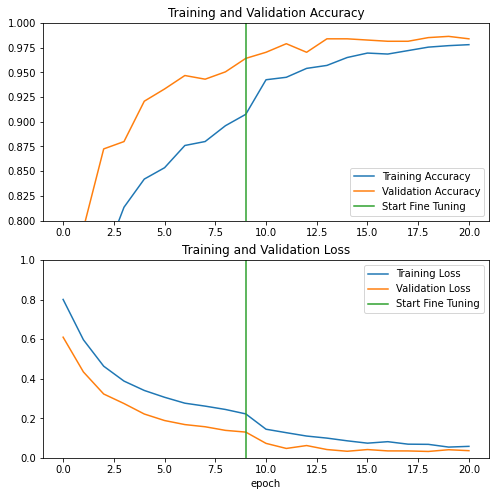

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finaly you can verify the performance of the model on new data using test set.

In [36]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/6 [====>.........................] - ETA: 0s - loss: 0.0065 - accuracy: 1.0000

6/6 [==============================] - ETA: 0s - loss: 0.0650 - accuracy: 0.9740

6/6 [==============================] - 0s 13ms/step - loss: 0.0650 - accuracy: 0.9740


Test accuracy : 0.9739583134651184


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [1 0 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1 1]
Labels:
 [1 0 1 1 1 0 0 1 0 0 1 1 1 0 0 1 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1 1]


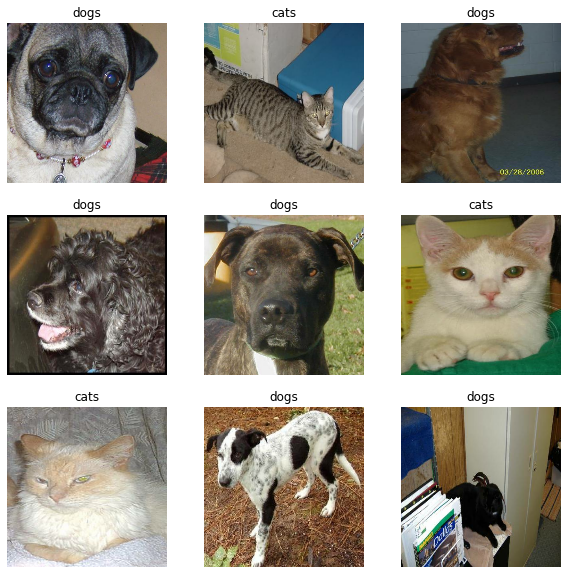

In [37]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
